# Moments Parameter Analysis: Best Fit vs Ground Truth

This notebook analyzes the moments optimization results from demographic inference experiments, comparing best fit parameters against ground truth values and visualizing parameter distributions across replicates.

## Import Required Libraries

Import necessary libraries for data manipulation and visualization.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from pathlib import Path
import glob
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully!")

Libraries imported successfully!


## Configuration and Path Setup

Define paths to the experiment directories containing simulations and results.

In [27]:
# Define base paths - MODIFY THESE FOR YOUR EXPERIMENT
EXPERIMENT_NAME = 'split_isolation'  # Change this to your experiment name
base_path = Path(f'/home/akapoor/kernlab/Infer_Demography/experiments/{EXPERIMENT_NAME}')
simulations_path = base_path / 'simulations'
runs_path = base_path / 'runs'

# Analysis configuration
MAX_SIMS_TO_PLOT = 100  # Set to a number (e.g., 10) to limit simulations plotted, or None for all
RANDOM_SUBSET = False    # If True and MAX_SIMS_TO_PLOT is set, randomly sample simulations

# Output directory for results
output_dir = Path('/home/akapoor/kernlab/Infer_Demography/notebooks/analysis_results')
output_dir.mkdir(exist_ok=True)

print(f"Configuration:")
print(f"  Experiment: {EXPERIMENT_NAME}")
print(f"  Base path: {base_path}")
print(f"  Simulations path: {simulations_path}")
print(f"  Runs path: {runs_path}")
print(f"  Output directory: {output_dir}")
print(f"  Max simulations to plot: {MAX_SIMS_TO_PLOT if MAX_SIMS_TO_PLOT else 'All'}")
print(f"  Random subset: {RANDOM_SUBSET}")

# Verify paths exist
print(f"\nPath verification:")
print(f"  Base path exists: {base_path.exists()}")
print(f"  Simulations exists: {simulations_path.exists()}")
print(f"  Runs exists: {runs_path.exists()}")

if not all([base_path.exists(), simulations_path.exists(), runs_path.exists()]):
    print("\n⚠️  WARNING: Some paths don't exist. Please check the EXPERIMENT_NAME and paths.")
else:
    print("\n✅ All paths verified successfully!")

Configuration:
  Experiment: split_isolation
  Base path: /home/akapoor/kernlab/Infer_Demography/experiments/split_isolation
  Simulations path: /home/akapoor/kernlab/Infer_Demography/experiments/split_isolation/simulations
  Runs path: /home/akapoor/kernlab/Infer_Demography/experiments/split_isolation/runs
  Output directory: /home/akapoor/kernlab/Infer_Demography/notebooks/analysis_results
  Max simulations to plot: 100
  Random subset: False

Path verification:
  Base path exists: True
  Simulations exists: True
  Runs exists: True

✅ All paths verified successfully!


## Data Loading Functions

Define comprehensive functions to load ground truth parameters and moments results.

In [28]:
def load_ground_truth_parameters(simulations_path, max_sims=None, random_subset=False):
    """Load ground truth parameters from simulation directories."""
    ground_truth = {}
    
    print("Loading ground truth parameters...")
    
    # Get all simulation directories first
    all_sim_dirs = sorted([d for d in simulations_path.glob('*') if d.is_dir()])
    
    # Apply simulation limit if specified
    if max_sims and max_sims < len(all_sim_dirs):
        if random_subset:
            import random
            selected_dirs = random.sample(all_sim_dirs, max_sims)
        else:
            selected_dirs = all_sim_dirs[:max_sims]
        print(f"  Selected {len(selected_dirs)} of {len(all_sim_dirs)} simulations ({'random' if random_subset else 'first N'})")
        sim_dirs_to_process = selected_dirs
    else:
        sim_dirs_to_process = all_sim_dirs
    
    # Iterate through selected simulation directories
    for sim_dir in sorted(sim_dirs_to_process):
        sim_id = sim_dir.name
        param_file = sim_dir / 'sampled_params.pkl'
        
        if param_file.exists():
            try:
                with open(param_file, 'rb') as f:
                    params = pickle.load(f)
                ground_truth[sim_id] = params
            except Exception as e:
                print(f"  Error loading {param_file}: {e}")
        else:
            print(f"  Parameter file not found: {param_file}")
    
    print(f"  Loaded ground truth for {len(ground_truth)} simulations")
    return ground_truth

def load_moments_results(runs_path, max_sims=None, random_subset=False):
    """Load moments best fit results from run directories."""
    moments_results = {}
    
    print("Loading moments results...")
    
    # Search for moments result files in run directories
    all_run_dirs = sorted(runs_path.glob('run_*_*'))
    print(f"  Found {len(all_run_dirs)} run directories")
    
    # Parse run directories to get simulation IDs
    sim_run_mapping = {}
    for run_dir in all_run_dirs:
        if run_dir.is_dir():
            run_name = run_dir.name
            # Parse run name (format: run_sim_rep, e.g., run_0_1)
            parts = run_name.split('_')
            if len(parts) >= 3:
                sim_id = parts[1]
                rep_id = parts[2]
                
                if sim_id not in sim_run_mapping:
                    sim_run_mapping[sim_id] = []
                sim_run_mapping[sim_id].append((run_dir, rep_id))
    
    # Apply simulation limit if specified
    all_sim_ids = sorted(sim_run_mapping.keys())
    if max_sims and max_sims < len(all_sim_ids):
        if random_subset:
            import random
            selected_sims = random.sample(all_sim_ids, max_sims)
        else:
            selected_sims = all_sim_ids[:max_sims]
        print(f"  Selected {len(selected_sims)} of {len(all_sim_ids)} simulations ({'random' if random_subset else 'first N'})")
        sims_to_process = selected_sims
    else:
        sims_to_process = all_sim_ids
    
    # Process selected simulations
    for sim_id in sims_to_process:
        if sim_id in sim_run_mapping:
            for run_dir, rep_id in sim_run_mapping[sim_id]:
                moments_dir = run_dir / 'inferences' / 'moments'
                
                if not moments_dir.exists():
                    continue
                    
                # Look for moments output files
                possible_files = [
                    moments_dir / 'best_fit.pkl',
                    moments_dir / 'fit_params.pkl',
                    moments_dir / 'optimization_results.pkl',
                    moments_dir / 'moments_results.pkl',
                    moments_dir / 'results.pkl'
                ]
                
                result_data = {}
                
                # Load all available result files
                for result_file in possible_files:
                    if result_file.exists():
                        try:
                            with open(result_file, 'rb') as f:
                                data = pickle.load(f)
                            result_data[result_file.name] = data
                        except Exception as e:
                            print(f"  Error loading {result_file}: {e}")
                
                if result_data:
                    if sim_id not in moments_results:
                        moments_results[sim_id] = {}
                    
                    moments_results[sim_id][rep_id] = {
                        'results': result_data,
                        'directory': moments_dir
                    }
    
    print(f"  Loaded moments results for {len(moments_results)} simulations")
    return moments_results

def extract_moments_parameters(results_data):
    """Extract parameter values from moments results data structure."""
    params = {}
    likelihood = None
    
    # Try to extract from different file types
    for file_name, data in results_data.items():
        
        if file_name == 'best_fit.pkl':
            if isinstance(data, dict):
                # Look for parameter keys
                param_keys = ['best_params', 'optimal_params', 'parameters', 'params']
                for key in param_keys:
                    if key in data:
                        if isinstance(data[key], dict):
                            params.update(data[key])
                        elif isinstance(data[key], (list, tuple, np.ndarray)):
                            # Map to parameter names (adjust for your model)
                            param_names = ['N1', 'N2', 'm12', 'm21', 't_split', 'N0']
                            if len(data[key]) <= len(param_names):
                                params.update(dict(zip(param_names[:len(data[key])], data[key])))
                        break
                
                # Look for likelihood
                ll_keys = ['best_lls', 'likelihood', 'll', 'log_likelihood', 'best_ll']
                for key in ll_keys:
                    if key in data:
                        likelihood = data[key]
                        break
            
            elif isinstance(data, (list, tuple, np.ndarray)):
                # If best_fit.pkl contains just parameter values
                param_names = ['N1', 'N2', 'm12', 'm21', 't_split', 'N0']
                if len(data) <= len(param_names):
                    params = dict(zip(param_names[:len(data)], data))
        
        elif file_name == 'fit_params.pkl':
            if isinstance(data, dict):
                params.update(data)
            elif isinstance(data, (list, tuple, np.ndarray)):
                param_names = ['N1', 'N2', 'm12', 'm21', 't_split', 'N0']
                if len(data) <= len(param_names):
                    params.update(dict(zip(param_names[:len(data)], data)))
    
    # Add likelihood to params if found
    if likelihood is not None:
        params['log_likelihood'] = likelihood
    
    return params

print("Data loading functions defined successfully!")

Data loading functions defined successfully!


## Load Data

Load ground truth parameters and moments optimization results.

In [29]:
# Load ground truth parameters with simulation limit
print(f"Loading data with simulation limit: {MAX_SIMS_TO_PLOT if MAX_SIMS_TO_PLOT else 'All simulations'}")
ground_truth_params = load_ground_truth_parameters(simulations_path, max_sims=MAX_SIMS_TO_PLOT, random_subset=RANDOM_SUBSET)

# Load moments results with simulation limit  
moments_results = load_moments_results(runs_path, max_sims=MAX_SIMS_TO_PLOT, random_subset=RANDOM_SUBSET)

# Display summary
print(f"\nData Loading Summary:")
print(f"  Ground truth simulations: {len(ground_truth_params)}")
print(f"  Moments results simulations: {len(moments_results)}")

if MAX_SIMS_TO_PLOT:
    print(f"  Limited to: {MAX_SIMS_TO_PLOT} simulations ({'random' if RANDOM_SUBSET else 'first N'})")

if ground_truth_params:
    first_sim = list(ground_truth_params.keys())[0]
    print(f"\nExample parameters for simulation {first_sim}:")
    for key, value in ground_truth_params[first_sim].items():
        print(f"  {key}: {value:.6f}" if isinstance(value, float) else f"  {key}: {value}")

if moments_results:
    print(f"\nMoments results per simulation:")
    for sim_id, sim_results in sorted(moments_results.items()):
        print(f"  Simulation {sim_id}: {len(sim_results)} replicates")

# Check data availability
if not ground_truth_params:
    print("\n⚠️  WARNING: No ground truth parameters loaded!")
if not moments_results:
    print("\n⚠️  WARNING: No moments results loaded!")
    
if ground_truth_params and moments_results:
    print("\n✅ Data loaded successfully!")

Loading data with simulation limit: 100
Loading ground truth parameters...
  Parameter file not found: /home/akapoor/kernlab/Infer_Demography/experiments/split_isolation/simulations/46/sampled_params.pkl
  Parameter file not found: /home/akapoor/kernlab/Infer_Demography/experiments/split_isolation/simulations/72/sampled_params.pkl
  Loaded ground truth for 98 simulations
Loading moments results...
  Found 25 run directories
  Loaded moments results for 25 simulations

Data Loading Summary:
  Ground truth simulations: 98
  Moments results simulations: 25
  Limited to: 100 simulations (first N)

Example parameters for simulation 0:
  N_anc: 26129.930627
  N_YRI: 23410.977293
  N_CEU: 23196.952512
  m_YRI_CEU: 0.000012
  T_split: 4025.143732

Moments results per simulation:
  Simulation 0: 1 replicates
  Simulation 1: 1 replicates
  Simulation 10: 1 replicates
  Simulation 11: 1 replicates
  Simulation 12: 1 replicates
  Simulation 13: 1 replicates
  Simulation 14: 1 replicates
  Simulati

## Create Comparison DataFrame

Process the loaded data into a comprehensive comparison dataframe.

In [30]:
import json

def create_moments_comparison_dataframe(ground_truth_params, moments_results, simulations_path):
    """Create a DataFrame comparing ground truth vs estimated parameters for moments, including sampled_coverage_percent."""
    comparison_data = []
    
    print("Creating comparison dataframe...")
    
    for sim_id in ground_truth_params.keys():
        # Load sampled_coverage_percent from bgs.meta.json
        meta_path = simulations_path / sim_id / "bgs.meta.json"
        if meta_path.exists():
            with open(meta_path, "r") as f:
                meta = json.load(f)
            sampled_coverage_percent = meta.get("sampled_coverage_percent", None)
        else:
            sampled_coverage_percent = None

        if sim_id in moments_results:
            gt_params = ground_truth_params[sim_id]
            
            for rep_id, rep_data in moments_results[sim_id].items():
                est_params = extract_moments_parameters(rep_data['results'])
                
                # Create a row for each parameter
                for param_name in gt_params.keys():
                    if param_name in est_params:
                        gt_val = gt_params[param_name]
                        est_val = est_params[param_name]
                        
                        comparison_data.append({
                            'simulation': sim_id,
                            'replicate': rep_id,
                            'parameter': param_name,
                            'ground_truth': gt_val,
                            'estimated': est_val,
                            'absolute_error': est_val - gt_val,
                            'relative_error': (est_val - gt_val) / gt_val if gt_val != 0 else np.nan,
                            'sampled_coverage_percent': sampled_coverage_percent
                        })
                
                # Add likelihood if available
                if 'log_likelihood' in est_params:
                    comparison_data.append({
                        'simulation': sim_id,
                        'replicate': rep_id,
                        'parameter': 'log_likelihood',
                        'ground_truth': np.nan,
                        'estimated': est_params['log_likelihood'],
                        'absolute_error': np.nan,
                        'relative_error': np.nan,
                        'sampled_coverage_percent': sampled_coverage_percent
                    })
    
    df = pd.DataFrame(comparison_data)
    print(f"  Created dataframe with {len(df)} rows")
    return df

In [31]:
# Re-create the comparison dataframe with sampled_coverage_percent
# Make sure the function definition above includes the sampled_coverage_percent field

df_moments_comparison = create_moments_comparison_dataframe(ground_truth_params, moments_results, simulations_path)

# Print columns and sample data to verify
print(df_moments_comparison)

Creating comparison dataframe...
  Created dataframe with 150 rows
    simulation replicate       parameter  ground_truth     estimated  \
0            0         0           N_anc  26129.930627   7000.054949   
1            0         0           N_YRI  23410.977293   9750.228622   
2            0         0           N_CEU  23196.952512   9443.578208   
3            0         0       m_YRI_CEU      0.000012      0.000037   
4            0         0         T_split   4025.143732   3550.332994   
..         ...       ...             ...           ...           ...   
145          9         0           N_YRI  26876.358092  10873.351502   
146          9         0           N_CEU  10815.864402   5014.620885   
147          9         0       m_YRI_CEU      0.000067      0.000100   
148          9         0         T_split   5837.823457   3991.873941   
149          9         0  log_likelihood           NaN  60445.458376   

     absolute_error  relative_error  sampled_coverage_percent  
0   

## Analysis Functions

Define functions for parameter analysis and visualization.

In [32]:
def plot_parameter_comparison(df, parameter_name, title_prefix="Moments", max_sims=None, random_subset=False):
    """Plot ground truth vs estimated values for a specific parameter, colorized by sampled_coverage_percent."""
    param_data = df[(df['parameter'] == parameter_name) & (df['parameter'] != 'log_likelihood')]
    
    if len(param_data) == 0:
        print(f"No data found for parameter {parameter_name}")
        return None
    
    # Filter simulations if requested
    unique_sims = sorted(param_data['simulation'].unique())
    if max_sims and max_sims < len(unique_sims):
        if random_subset:
            import random
            selected_sims = random.sample(unique_sims, max_sims)
        else:
            selected_sims = unique_sims[:max_sims]
        param_data = param_data[param_data['simulation'].isin(selected_sims)]
        unique_sims = sorted(selected_sims)
        print(f"  Plotting {len(unique_sims)} of {len(sorted(df[df['parameter'] == parameter_name]['simulation'].unique()))} simulations for {parameter_name}")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot: Ground truth vs Estimated
    ax1 = axes[0]
    
    # Color by sampled_coverage_percent (continuous colormap)
    coverage = param_data['sampled_coverage_percent']
    scatter = ax1.scatter(param_data['ground_truth'], param_data['estimated'],
                         c=coverage, cmap='viridis', alpha=0.7, s=50, edgecolor='black', linewidth=0.5)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('Sampled Coverage Percent')
    
    # Add identity line
    min_val = min(param_data['ground_truth'].min(), param_data['estimated'].min())
    max_val = max(param_data['ground_truth'].max(), param_data['estimated'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect fit')
    
    ax1.set_xlabel(f'Ground Truth {parameter_name}')
    ax1.set_ylabel(f'Estimated {parameter_name}')
    ax1.set_title(f'{title_prefix} - {parameter_name}: Ground Truth vs Estimated')
    ax1.grid(True, alpha=0.3)
    
    # Show legend only if reasonable number of simulations
    # (Legend not needed for continuous colormap)
    
    # Relative error histogram
    ax2 = axes[1]
    valid_errors = param_data['relative_error'].dropna()
    
    if len(valid_errors) > 0:
        ax2.hist(valid_errors, bins=20, alpha=0.7, edgecolor='black', color='skyblue')
        ax2.axvline(0, color='red', linestyle='--', label='Perfect estimate')
        ax2.axvline(valid_errors.median(), color='blue', linestyle='-', 
                   label=f'Median: {valid_errors.median():.3f}')
        ax2.axvline(valid_errors.mean(), color='green', linestyle=':', 
                   label=f'Mean: {valid_errors.mean():.3f}')
    
    ax2.set_xlabel('Relative Error')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{title_prefix} - {parameter_name}: Relative Error Distribution')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    valid_data = param_data.dropna(subset=['ground_truth', 'estimated', 'relative_error'])
    if len(valid_data) > 0:
        correlation = valid_data['ground_truth'].corr(valid_data['estimated'])
        print(f"\n{title_prefix} Summary for {parameter_name}:")
        print(f"  Number of estimates: {len(valid_data)}")
        print(f"  Correlation coefficient: {correlation:.4f}")
        print(f"  Mean relative error: {valid_data['relative_error'].mean():.4f}")
        print(f"  Median relative error: {valid_data['relative_error'].median():.4f}")
        print(f"  Std relative error: {valid_data['relative_error'].std():.4f}")
        print(f"  RMSE: {np.sqrt((valid_data['absolute_error']**2).mean()):.4f}")
    
    return fig

## Parameter-wise Analysis

Analyze each parameter individually with scatter plots and error distributions.

Analyzing 5 parameters: ['N_anc', 'N_YRI', 'N_CEU', 'm_YRI_CEU', 'T_split']
Limiting plots to 25 of 25 simulations


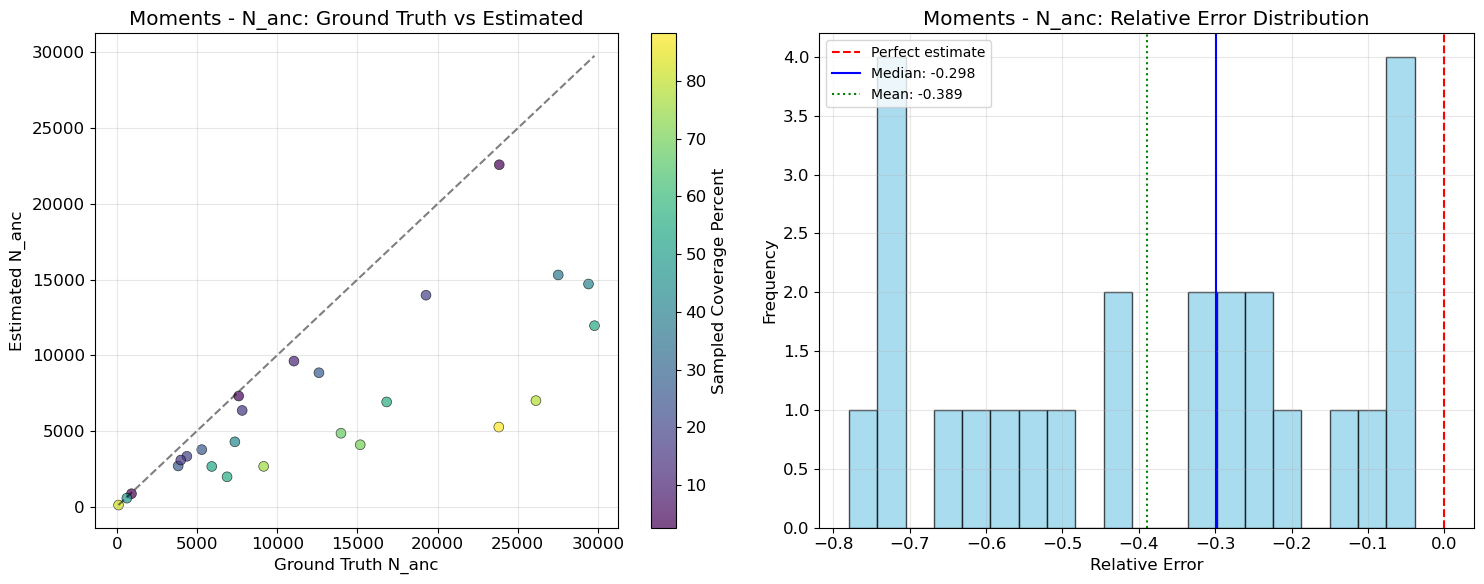


Moments Summary for N_anc:
  Number of estimates: 25
  Correlation coefficient: 0.7763
  Mean relative error: -0.3888
  Median relative error: -0.2985
  Std relative error: 0.2500
  RMSE: 8576.5748

--------------------------------------------------------------------------------



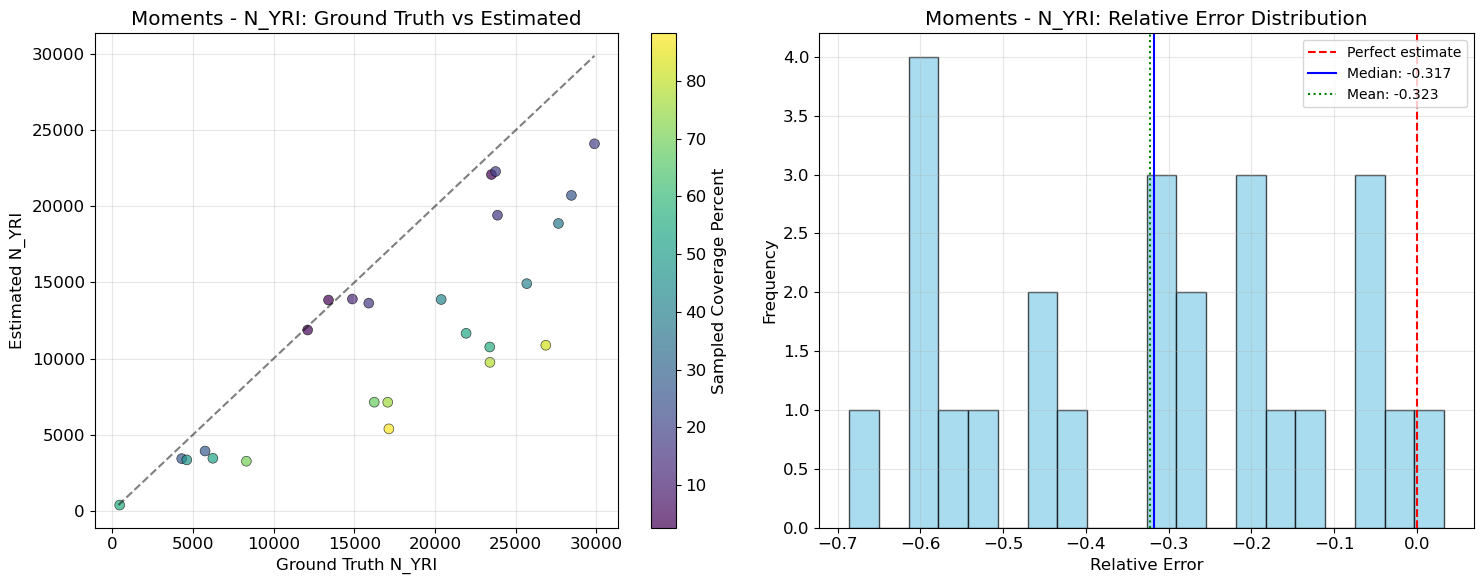


Moments Summary for N_YRI:
  Number of estimates: 25
  Correlation coefficient: 0.8207
  Mean relative error: -0.3227
  Median relative error: -0.3175
  Std relative error: 0.2145
  RMSE: 7554.4288

--------------------------------------------------------------------------------



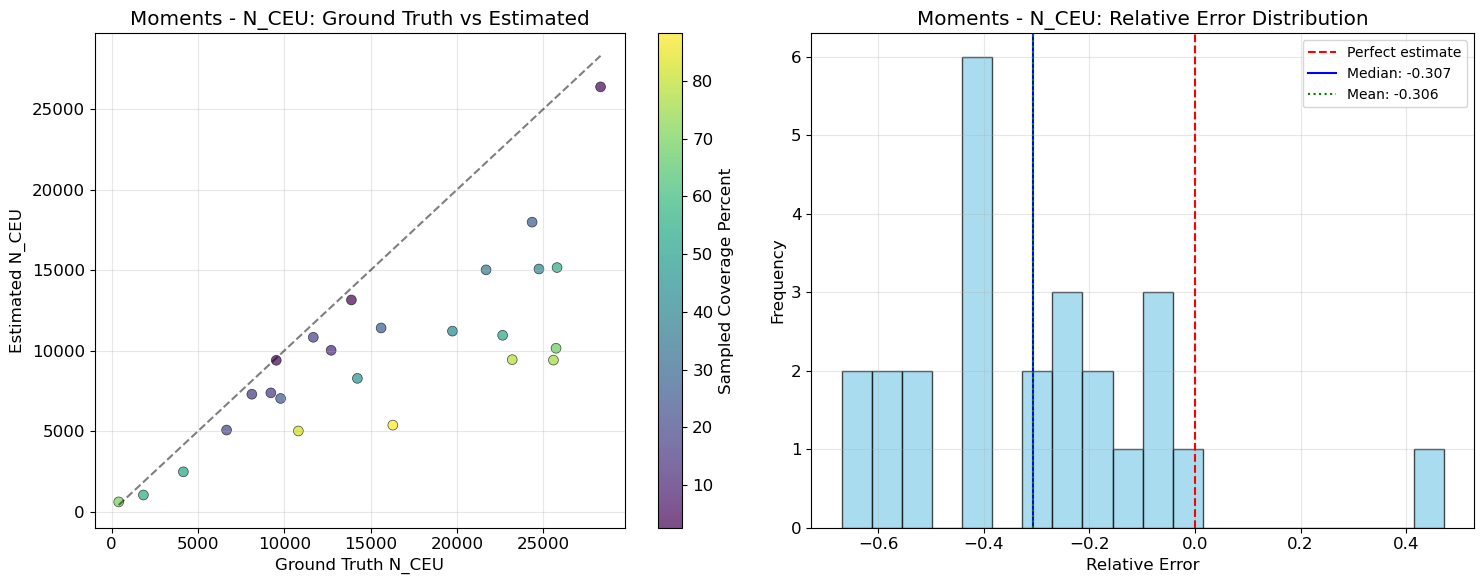


Moments Summary for N_CEU:
  Number of estimates: 25
  Correlation coefficient: 0.7942
  Mean relative error: -0.3061
  Median relative error: -0.3073
  Std relative error: 0.2514
  RMSE: 7561.6585

--------------------------------------------------------------------------------



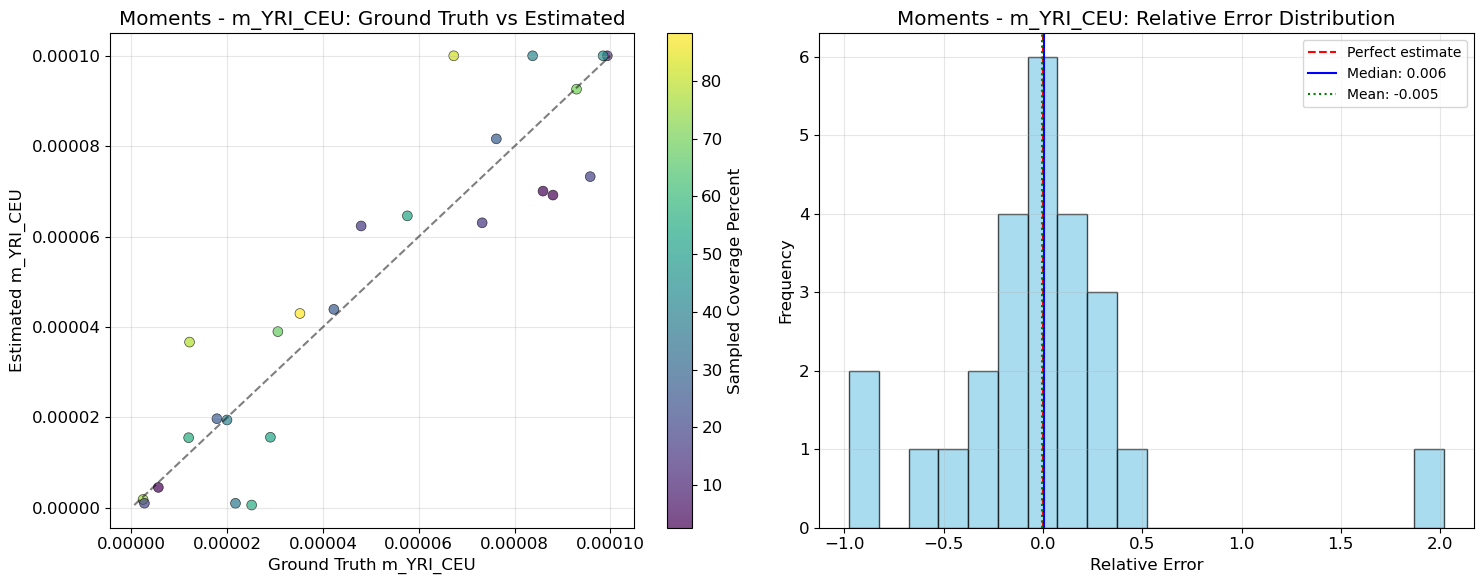


Moments Summary for m_YRI_CEU:
  Number of estimates: 25
  Correlation coefficient: 0.9194
  Mean relative error: -0.0048
  Median relative error: 0.0064
  Std relative error: 0.5560
  RMSE: 0.0000

--------------------------------------------------------------------------------



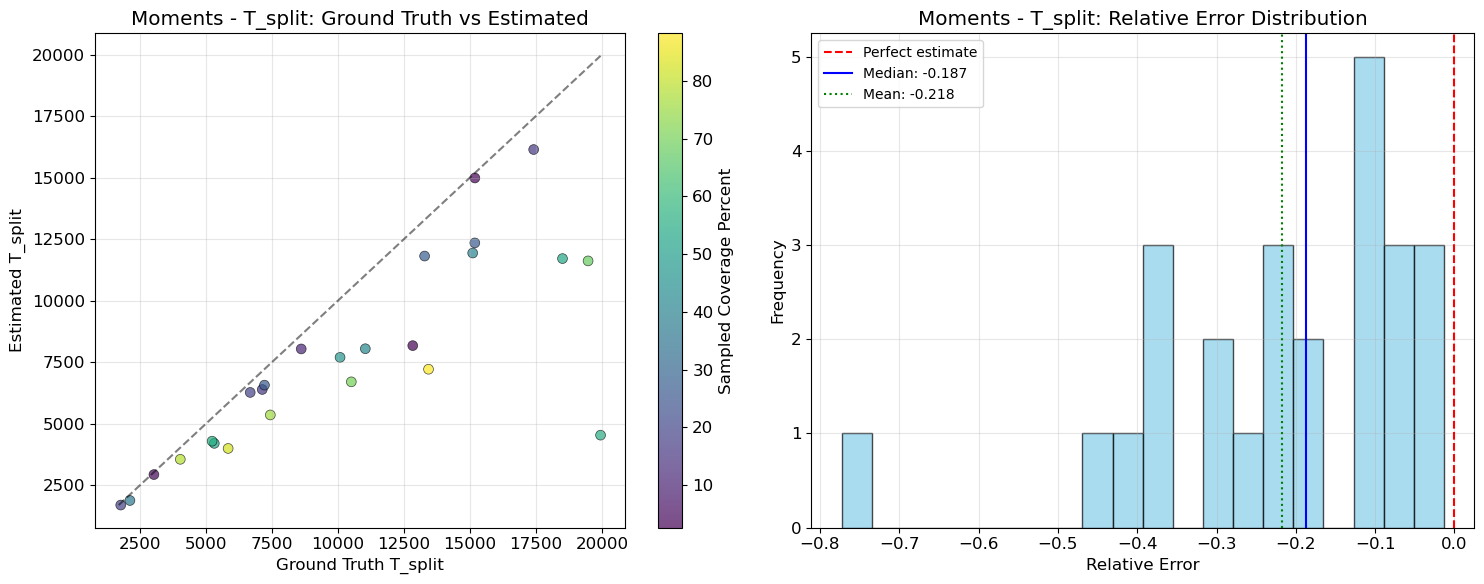


Moments Summary for T_split:
  Number of estimates: 25
  Correlation coefficient: 0.7892
  Mean relative error: -0.2179
  Median relative error: -0.1870
  Std relative error: 0.1736
  RMSE: 4330.4305

--------------------------------------------------------------------------------



In [33]:
if not df_moments_comparison.empty:
    # Get parameters to analyze (excluding log_likelihood)
    params_to_plot = [p for p in df_moments_comparison['parameter'].unique() if p != 'log_likelihood']
    
    print(f"Analyzing {len(params_to_plot)} parameters: {params_to_plot}")
    if MAX_SIMS_TO_PLOT:
        total_sims = len(df_moments_comparison['simulation'].unique())
        print(f"Limiting plots to {min(MAX_SIMS_TO_PLOT, total_sims)} of {total_sims} simulations")
    print("=" * 60)
    
    # Plot each parameter
    for param in params_to_plot:
        plot_parameter_comparison(df_moments_comparison, param, "Moments", 
                                MAX_SIMS_TO_PLOT, RANDOM_SUBSET)
        print("\n" + "-"*80 + "\n")
        
else:
    print("No data available for parameter analysis")

## Statistical Summary

Calculate and display comprehensive statistics for all parameters.

In [9]:
if not df_moments_comparison.empty:
    # Calculate statistics
    moments_stats_df = calculate_parameter_statistics(df_moments_comparison, "Moments")
    
    if not moments_stats_df.empty:
        print("Detailed Parameter Statistics:")
        print("=" * 60)
        
        # Display detailed stats table
        display_cols = ['parameter', 'simulation', 'ground_truth', 'mean_estimate', 
                       'relative_bias', 'relative_rmse', 'n_replicates']
        print(moments_stats_df[display_cols].round(4).to_string(index=False))
        
        # Overall summary by parameter
        print("\n\nOverall Summary by Parameter:")
        print("=" * 50)
        
        overall_summary = moments_stats_df.groupby('parameter').agg({
            'relative_bias': ['mean', 'std', 'median'],
            'relative_rmse': ['mean', 'std', 'median'],
            'n_replicates': 'sum'
        }).round(4)
        
        print(overall_summary.to_string())
    
    else:
        print("No valid statistics calculated")
        
else:
    print("No data available for statistical analysis")

Detailed Parameter Statistics:
      parameter simulation  ground_truth  mean_estimate  relative_bias  relative_rmse  n_replicates
             N0          0    19974.0666     19974.0666        -0.0000         0.0000           100
             N0          1     7914.2613      7914.2613         0.0000         0.0000           100
             N0         10    15302.2277     15302.2277         0.0000         0.0000           100
             N0        100    19835.4410     19835.4410        -0.0000         0.0000           100
             N0        101    10146.7630     10146.7630         0.0000         0.0000           100
             N0        102     7264.2765      7264.2765         0.0000         0.0000           100
             N0        103    14177.8707     14177.8707         0.0000         0.0000           100
             N0        104    19804.2745     19804.2745         0.0000         0.0000           100
             N0        105    18764.0536     18764.0536         0.000

## Best Likelihood Analysis

For each simulation, identify the replicate with the highest likelihood and analyze those best estimates.

Best Likelihood Analysis
Found best estimates for 10 simulations
Parameters: ['AFR', 'EUR_bottleneck', 'EUR_recover', 'N0', 'T_AFR_EUR_split', 'T_AFR_expansion', 'T_EUR_expansion']

Best Estimates Statistical Summary:
--------------------------------------------------

AFR:
  Count: 10
  Mean relative error: 0.0000
  Median relative error: 0.0000
  Std relative error: 0.0000
  Within 5% accuracy: 10/10 (100.0%)
  Within 10% accuracy: 10/10 (100.0%)

EUR_bottleneck:
  Count: 10
  Mean relative error: 0.0551
  Median relative error: -0.0023
  Std relative error: 0.2267
  Within 5% accuracy: 4/10 (40.0%)
  Within 10% accuracy: 8/10 (80.0%)

EUR_recover:
  Count: 10
  Mean relative error: 0.0051
  Median relative error: 0.0015
  Std relative error: 0.0678
  Within 5% accuracy: 6/10 (60.0%)
  Within 10% accuracy: 9/10 (90.0%)

N0:
  Count: 10
  Mean relative error: 0.0000
  Median relative error: 0.0000
  Std relative error: 0.0000
  Within 5% accuracy: 10/10 (100.0%)
  Within 10% accuracy:

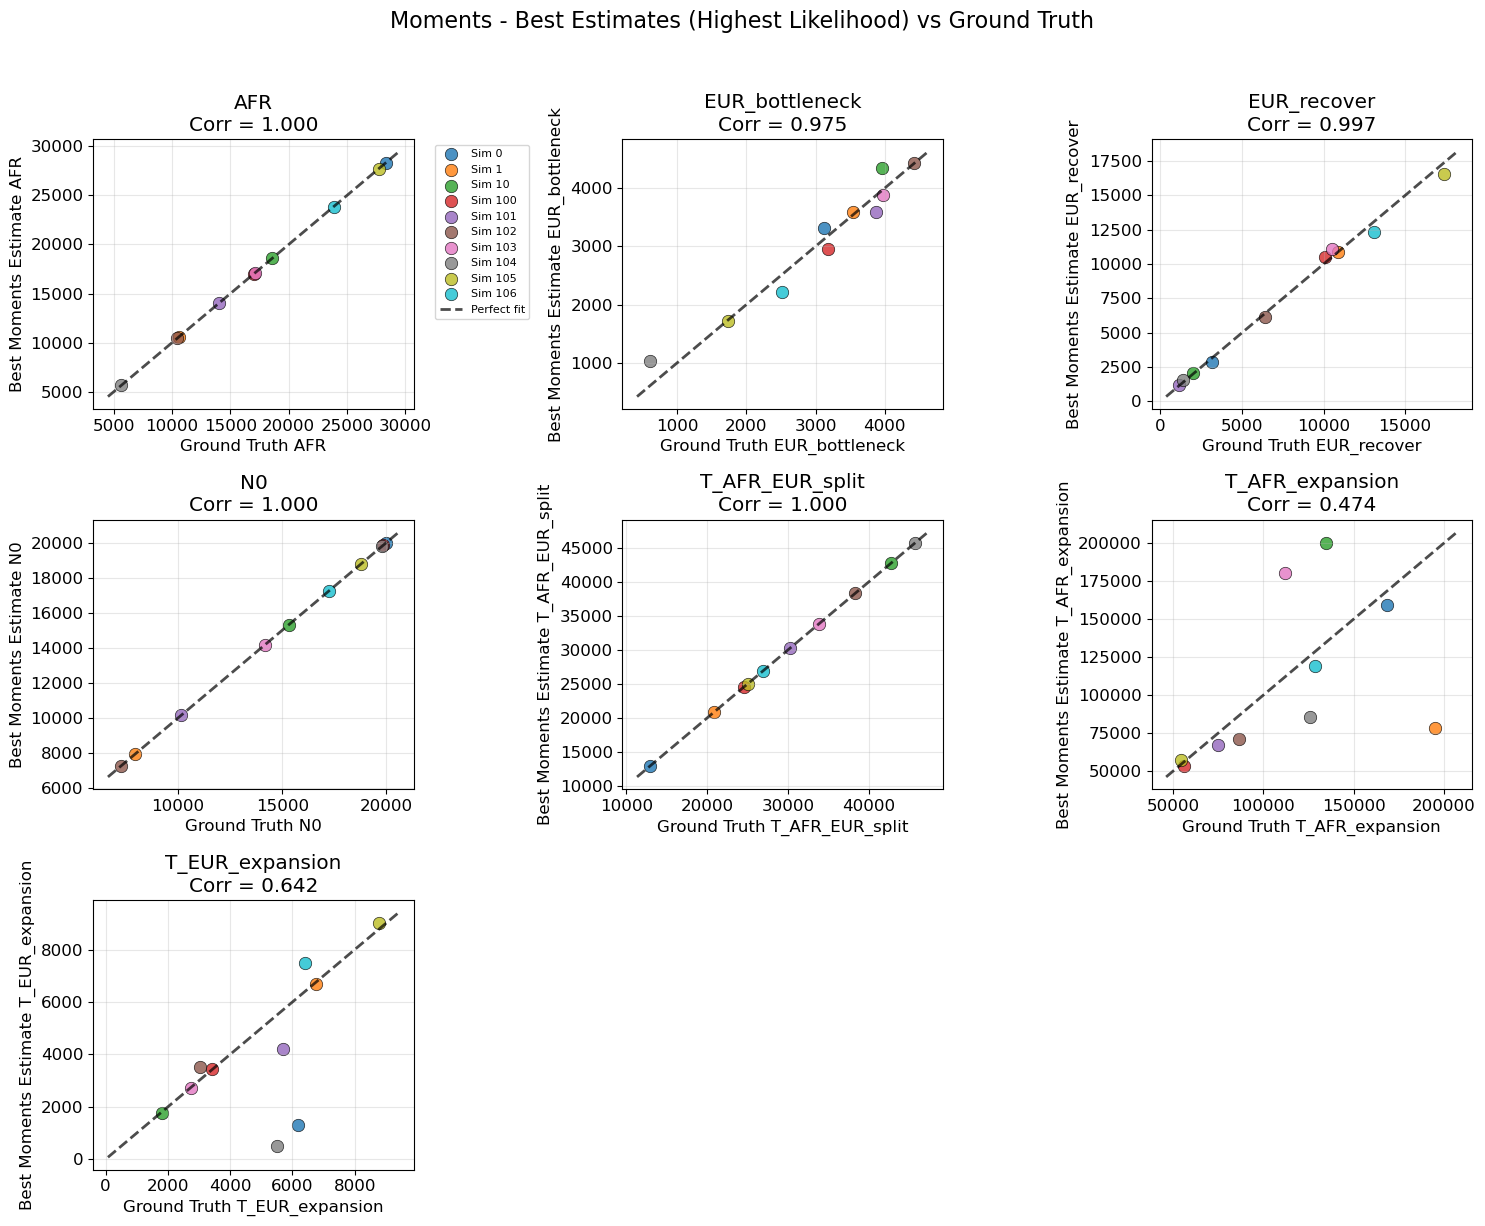

In [10]:
def get_best_estimates_per_simulation(df):
    """Get the best parameter estimates (highest likelihood) for each simulation."""
    
    # Filter to only likelihood data
    ll_data = df[df['parameter'] == 'log_likelihood'].copy()
    
    if ll_data.empty:
        print("No likelihood data found - cannot identify best estimates")
        return None
    
    # For each simulation, find the replicate with highest likelihood
    best_estimates = []
    
    for sim_id in ll_data['simulation'].unique():
        sim_ll_data = ll_data[ll_data['simulation'] == sim_id]
        
        # Find replicate with maximum likelihood
        best_rep_idx = sim_ll_data['estimated'].idxmax()
        best_rep_row = sim_ll_data.loc[best_rep_idx]
        best_replicate = best_rep_row['replicate']
        best_likelihood = best_rep_row['estimated']
        
        # Get all parameter estimates for this simulation and replicate
        sim_rep_data = df[(df['simulation'] == sim_id) & (df['replicate'] == best_replicate)]
        
        # Store the best estimates
        for _, row in sim_rep_data.iterrows():
            if row['parameter'] != 'log_likelihood':
                best_estimates.append({
                    'simulation': sim_id,
                    'replicate': best_replicate,
                    'parameter': row['parameter'],
                    'ground_truth': row['ground_truth'],
                    'best_estimate': row['estimated'],
                    'best_likelihood': best_likelihood,
                    'absolute_error': row['estimated'] - row['ground_truth'],
                    'relative_error': (row['estimated'] - row['ground_truth']) / row['ground_truth'] if row['ground_truth'] != 0 else np.nan
                })
    
    return pd.DataFrame(best_estimates)

def plot_best_estimates_vs_ground_truth(best_df, title_prefix="Moments", max_sims=None, random_subset=False):
    """Plot the best parameter estimates vs ground truth for all parameters."""
    
    if best_df is None or best_df.empty:
        print("No best estimates data available for plotting")
        return None
    
    # Filter simulations if requested
    unique_sims = sorted(best_df['simulation'].unique())
    if max_sims and max_sims < len(unique_sims):
        if random_subset:
            import random
            selected_sims = random.sample(unique_sims, max_sims)
        else:
            selected_sims = unique_sims[:max_sims]
        best_df = best_df[best_df['simulation'].isin(selected_sims)]
        unique_sims = sorted(selected_sims)
        print(f"  Plotting best estimates for {len(unique_sims)} of {len(sorted(best_df['simulation'].unique())) + len(unique_sims) - len(selected_sims)} simulations")
    
    parameters = sorted(best_df['parameter'].unique())
    n_params = len(parameters)
    
    if n_params == 0:
        print("No parameters found for plotting")
        return None
    
    # Create subplots
    cols = min(3, n_params)
    rows = (n_params + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_params == 1:
        axes = np.array([axes])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    # Color mapping for simulations
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_sims)))
    sim_color_map = {sim: colors[i] for i, sim in enumerate(unique_sims)}
    
    for i, param in enumerate(parameters):
        row = i // cols
        col = i % cols
        
        if n_params == 1:
            ax = axes[0]
        elif rows == 1:
            ax = axes[0, col] if cols > 1 else axes[col]
        else:
            ax = axes[row, col]
        
        param_data = best_df[best_df['parameter'] == param]
        
        # Scatter plot colored by simulation
        for sim_id in unique_sims:
            sim_data = param_data[param_data['simulation'] == sim_id]
            if not sim_data.empty:
                ax.scatter(sim_data['ground_truth'], sim_data['best_estimate'], 
                          color=sim_color_map[sim_id], alpha=0.8, s=80, 
                          label=f'Sim {sim_id}', edgecolors='black', linewidth=0.5)
        
        # Add identity line
        min_val = min(param_data['ground_truth'].min(), param_data['best_estimate'].min())
        max_val = max(param_data['ground_truth'].max(), param_data['best_estimate'].max())
        margin = 0.05 * (max_val - min_val)
        ax.plot([min_val-margin, max_val+margin], [min_val-margin, max_val+margin], 
                'k--', alpha=0.7, linewidth=2, label='Perfect fit')
        
        # Calculate and display correlation
        correlation = param_data['ground_truth'].corr(param_data['best_estimate'])
        
        ax.set_xlabel(f'Ground Truth {param}')
        ax.set_ylabel(f'Best {title_prefix} Estimate {param}')
        ax.set_title(f'{param}\nCorr = {correlation:.3f}')
        ax.grid(True, alpha=0.3)
        
        # Show legend only for first subplot if reasonable number of simulations
        if i == 0 and len(unique_sims) <= 12:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Hide empty subplots
    for i in range(n_params, rows * cols):
        row = i // cols
        col = i % cols
        if rows == 1:
            if cols > 1:
                axes[0, col].set_visible(False)
            else:
                axes[col].set_visible(False)
        else:
            axes[row, col].set_visible(False)
    
    plt.suptitle(f'{title_prefix} - Best Estimates (Highest Likelihood) vs Ground Truth', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return fig

# Perform best likelihood analysis
if not df_moments_comparison.empty:
    print("Best Likelihood Analysis")
    print("=" * 40)
    
    best_moments_df = get_best_estimates_per_simulation(df_moments_comparison)
    
    if best_moments_df is not None and not best_moments_df.empty:
        print(f"Found best estimates for {len(best_moments_df['simulation'].unique())} simulations")
        print(f"Parameters: {sorted(best_moments_df['parameter'].unique())}")
        
        # Display summary statistics
        print(f"\nBest Estimates Statistical Summary:")
        print("-" * 50)
        
        for param in sorted(best_moments_df['parameter'].unique()):
            param_data = best_moments_df[best_moments_df['parameter'] == param]
            
            print(f"\n{param}:")
            print(f"  Count: {len(param_data)}")
            print(f"  Mean relative error: {param_data['relative_error'].mean():.4f}")
            print(f"  Median relative error: {param_data['relative_error'].median():.4f}")
            print(f"  Std relative error: {param_data['relative_error'].std():.4f}")
            
            # Accuracy metrics
            within_5pct = (np.abs(param_data['relative_error']) <= 0.05).sum()
            within_10pct = (np.abs(param_data['relative_error']) <= 0.10).sum()
            total = len(param_data)
            print(f"  Within 5% accuracy: {within_5pct}/{total} ({100*within_5pct/total:.1f}%)")
            print(f"  Within 10% accuracy: {within_10pct}/{total} ({100*within_10pct/total:.1f}%)")
        
        # Create the visualization
        print(f"\nCreating best estimates visualization...")
        plot_best_estimates_vs_ground_truth(best_moments_df, "Moments", 
                                           MAX_SIMS_TO_PLOT, RANDOM_SUBSET)
        
    else:
        print("Could not create best estimates dataframe - check likelihood data")
        best_moments_df = None
        
else:
    print("No comparison data available for best likelihood analysis")
    best_moments_df = None